In [1]:
%pylab inline

import sys, argparse
from scipy import ndimage
import matplotlib.pyplot as plt
import pandas as pd
import sys
import pickle
import gzip
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid.anchored_artists import AnchoredText
import matplotlib
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.unicode'] = True

sys.path.append('../../../')
from tractionforce.elasticity import *
import gc
from tractionforce.norms import *
from tractionforce.problem import *

from joblib import Parallel, delayed
import multiprocessing

def read_data(filename):

    # read the boundary points and get a mask
    raw_data = np.loadtxt(filename,skiprows=0)
    coords = raw_data[:,:2]
    deflection = raw_data[:,2]
    boundary = raw_data[:,3]
    return  coords, deflection, boundary

def latex_float(f):
    float_str = "{0:.2g}".format(f)
    if "e" in float_str:
        base, exponent = float_str.split("e")
        return r"{0} \times 10^{{{1}}}".format(base, int(exponent))
    else:
        return float_str
    
def extractn(inlist,n):
    try:
        return inlist[n]
    except:
        return None

Populating the interactive namespace from numpy and matplotlib


In [2]:
pdata = pd.read_csv("./t2_generated.csv")


In [3]:
CUTOFF  = 12
N_SOLUTIONS = 64
gamma_vals = np.logspace(-4, -1, N_SOLUTIONS)



coords = np.array([pdata.x , pdata.y]).T
deflection_x = np.array(pdata.u_x)
deflection_y = np.array(pdata.u_y)
boundary = np.array(pdata.boundary)

x_obs_positions = sorted(set(coords[:, 0]))
y_obs_positions = sorted(set(coords[:, 1]))

dx = abs(x_obs_positions[1]-x_obs_positions[0])
dy = abs(y_obs_positions[1]-y_obs_positions[0])

N = len(x_obs_positions)
M = len(y_obs_positions)

boundary2d = boundary.reshape((N, M))
mask = np.zeros(boundary2d.shape)
for r in range(boundary2d.shape[1]):
    pts = np.where(boundary2d[:, r] == 1)
    
    if (len(pts[0]) > 0):
        mini = (min(min(pts)))
        maxi = max(max(pts))
        mask[ mini:maxi, r] = 1

distances2d = -ndimage.distance_transform_edt(mask) + ndimage.distance_transform_edt(1 - mask)
distances2d = distances2d.flatten()

condition_inside = distances2d<=10
condition_outside = (distances2d>10) * (distances2d<=CUTOFF+10)

del distances2d, mask, boundary2d
gc.collect()



0

$$
\int_\Omega \vert \sigma \vert \mathrm{d}\mathbf{x} 
$$

In [4]:
results = pickle.load(gzip.open('../results/isotropic_L1_synthetic_results_x_expanded.gz','rb'))

def extractn(inlist,n):
    try:
        return inlist[n]
    except:
        return None

x_1 = results[-1][0]
y_1 = results[-1][1]
del(results[-1])
x_min, x_max = 69.974999999999994, 133.72999999999999
y_min, y_max = 139.94999999999999, 189.71000000000001

results = results[:-15]

In [5]:
data_error = [extractn(res,2) for res in results]

reg_error = [extractn(res,3) for res in results]
lvals = [extractn(res,4) for res in results]

# kill all nones

data_error = [item for item in data_error if item is not None]
reg_error = [item for item in reg_error if item is not None]
lvals = [item for item in lvals if item is not None]

l_curve_distances = np.abs((reg_error[-1]-reg_error[0])*np.array(data_error) -  \
            (data_error[-1]-data_error[0])*np.array(reg_error)+data_error[-1]*reg_error[0]-reg_error[-1]*data_error[0])
best = np.argsort(l_curve_distances)[-1]
print(best)


37


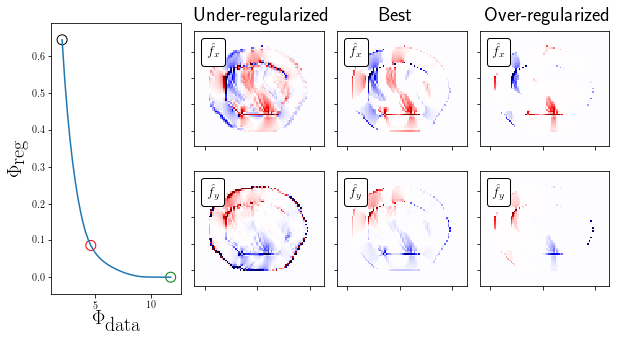

In [7]:
fig = plt.figure(figsize=(10,5))
maxval = 2e-4* 1e4
gs0 = gridspec.GridSpec(1,4, hspace = 0.1,wspace=0.1,width_ratios = [1,1,1,1])
gs_j = []

ax = []
im = []

ax += [plt.Subplot(fig, gs0[0,0])]
fig.add_subplot(ax[-1])
ax[-1].plot( data_error, reg_error)
ax[-1].scatter(data_error[best],reg_error[best],s=100, facecolors='none', edgecolors='r')
ax[-1].scatter(data_error[0],reg_error[0],s=100, facecolors='none', edgecolors='g')
ax[-1].scatter(data_error[-1],reg_error[-1],s=100, facecolors='none', edgecolors='black')
#ax[-1].annotate("$\quad\lambda=" + latex_float(lvals[best]) +"$", (data_error[best],reg_error[best]))
ax[-1].set_xlabel(r"$\Phi_{\textrm{data}}$",fontsize=20)
ax[-1].set_ylabel(r"$\Phi_{\textrm{reg}}$",fontsize=20)
#########################################

s_x = np.zeros(coords.shape[0])
s_y = np.zeros(coords.shape[0])

s_x[condition_inside] = results[0][0][0][:,0] * 1e2
s_y[condition_inside] = results[0][0][0][:,1] * 1e2

gs_j += [gridspec.GridSpecFromSubplotSpec(2,1,
                subplot_spec=gs0[1],
                hspace = 0.05,wspace=0.05)]

ax += [plt.Subplot(fig, gs_j[-1][0])]
fig.add_subplot(ax[-1])



im+= [ax[-1].pcolormesh(x_1,y_1,s_x.reshape((len(y_obs_positions),len(x_obs_positions))).T,rasterized=True,
                     cmap='seismic_r',vmax=maxval,vmin=-maxval)]
im[-1].axes.set_aspect('equal')

ax[-1].set_yticklabels([])
ax[-1].set_xticklabels([])
ax[-1].set_xlim((x_min - 30, x_max + 30))
ax[-1].set_ylim((y_min - 30, y_max + 30))

at = AnchoredText("$\hat{f}_{x}$",
              prop=dict(size=14), frameon=True,
              loc=2,
              )
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax[-1].add_artist(at)

ax += [plt.Subplot(fig, gs_j[-1][1])]
fig.add_subplot(ax[-1])
im+= [ax[-1].pcolormesh(x_1,y_1,s_y.reshape((len(y_obs_positions),len(x_obs_positions))).T,rasterized=True,
                     cmap='seismic_r',vmax=maxval,vmin=-maxval)]
im[-1].axes.set_aspect('equal')

ax[-1].set_yticklabels([])
ax[-1].set_xticklabels([])
ax[-1].set_xlim((x_min - 30, x_max + 30))
ax[-1].set_ylim((y_min - 30, y_max + 30))

at = AnchoredText("$\hat{f}_{y}$",
              prop=dict(size=14), frameon=True,
              loc=2,
              )
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax[-1].add_artist(at)

#########################################
#best = 9
s_x = np.zeros(coords.shape[0])
s_y = np.zeros(coords.shape[0])

s_x[condition_inside] = results[best][0][0][:,0] * 1e2
s_y[condition_inside] = results[best][0][0][:,1] * 1e2


gs_j += [gridspec.GridSpecFromSubplotSpec(2,1,
                subplot_spec=gs0[2],
                hspace = 0.05,wspace=0.05)]

ax += [plt.Subplot(fig, gs_j[-1][0])]
fig.add_subplot(ax[-1])
im+= [ax[-1].pcolormesh(x_1,y_1,s_x.reshape((len(y_obs_positions),len(x_obs_positions))).T,rasterized=True,
                     cmap='seismic_r',vmax=maxval,vmin=-maxval)]
im[-1].axes.set_aspect('equal')

ax[-1].set_yticklabels([])
ax[-1].set_xticklabels([])
ax[-1].set_xlim((x_min - 30, x_max + 30))
ax[-1].set_ylim((y_min - 30, y_max + 30))

at = AnchoredText("$\hat{f}_{x}$",
              prop=dict(size=14), frameon=True,
              loc=2,
              )
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax[-1].add_artist(at)

ax += [plt.Subplot(fig, gs_j[-1][1])]
fig.add_subplot(ax[-1])
im+= [ax[-1].pcolormesh(x_1,y_1,s_y.reshape((len(y_obs_positions),len(x_obs_positions))).T,rasterized=True,
                     cmap='seismic_r',vmax=maxval,vmin=-maxval)]
im[-1].axes.set_aspect('equal')

ax[-1].set_yticklabels([])
ax[-1].set_xticklabels([])
ax[-1].set_xlim((x_min - 30, x_max + 30))
ax[-1].set_ylim((y_min - 30, y_max + 30))

at = AnchoredText("$\hat{f}_{y}$",
              prop=dict(size=14), frameon=True,
              loc=2,
              )
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax[-1].add_artist(at)

#########################################

s_x = np.zeros(coords.shape[0])
s_y = np.zeros(coords.shape[0])


s_x[condition_inside] = results[-1][0][0][:,0] * 1e2
s_y[condition_inside] = results[-1][0][0][:,1] * 1e2

gs_j += [gridspec.GridSpecFromSubplotSpec(2,1,
                subplot_spec=gs0[3],
                hspace = 0.05,wspace=0.05)]

ax += [plt.Subplot(fig, gs_j[-1][0])]
fig.add_subplot(ax[-1])
im+= [ax[-1].pcolormesh(x_1,y_1,s_x.reshape((len(y_obs_positions),len(x_obs_positions))).T,rasterized=True,
                     cmap='seismic_r',vmax=maxval,vmin=-maxval)]
im[-1].axes.set_aspect('equal')

ax[-1].set_yticklabels([])
ax[-1].set_xticklabels([])
ax[-1].set_xlim((x_min - 30, x_max + 30))
ax[-1].set_ylim((y_min - 30, y_max + 30))

at = AnchoredText("$\hat{f}_{x}$",
              prop=dict(size=14), frameon=True,
              loc=2,
              )
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax[-1].add_artist(at)

ax += [plt.Subplot(fig, gs_j[-1][1])]
fig.add_subplot(ax[-1])
im+= [ax[-1].pcolormesh(x_1,y_1,s_y.reshape((len(y_obs_positions),len(x_obs_positions))).T,rasterized=True,
                     cmap='seismic_r',vmax=maxval,vmin=-maxval)]
im[-1].axes.set_aspect('equal')

ax[-1].set_yticklabels([])
ax[-1].set_xticklabels([])
ax[-1].set_xlim((x_min - 30, x_max + 30))
ax[-1].set_ylim((y_min - 30, y_max + 30))

at = AnchoredText("$\hat{f}_{y}$",
              prop=dict(size=14), frameon=True,
              loc=2,
              )
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax[-1].add_artist(at)

ax[1].text(40,230,r"Under-regularized",fontsize=20)
ax[3].text(80,230,r"Best",fontsize=20)
ax[5].text(45,230,r"Over-regularized",fontsize=20)

plt.savefig("../../figures/fig15.pdf",bbox_inches='tight', 
               transparent=True)   